In [1]:
# %pip install kagglehub
# %pip install pandas
# %pip install seaborn
# %pip install matplotlib
# %pip install scikit-learn
# %pip install qiskit_machine_learning
# %pip install qiskit
# %pip install joblib

In [2]:
import pickle
import kagglehub
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZZFeatureMap
from qiskit_algorithms.optimizers import SPSA
from qiskit_machine_learning.utils.loss_functions import SVCLoss
from qiskit_machine_learning.kernels import TrainableFidelityQuantumKernel
from qiskit_machine_learning.kernels.algorithms import QuantumKernelTrainer
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit.primitives import StatevectorSampler as Sampler
from joblib import Parallel, delayed
from tqdm import tqdm
from qiskit_machine_learning.utils import algorithm_globals

algorithm_globals.random_seed = 42

#### Download dataset

In [3]:
path = kagglehub.dataset_download("mohamedmustafashaban/heart-attack-prediction-dataset")

# print("Path to dataset files:", path)

In [4]:
df = pd.read_csv(f'{path}/heart_attack_prediction_dataset.csv')

#### For data visualisation

In [5]:
df_viz = df.copy()

#### Data Exploration

##### Display all columns

In [6]:
pd.set_option('display.max_columns', None)

In [7]:
df.head()

,Patient ID,Age,Sex,Cholesterol,Blood Pressure,Heart Rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Country,Continent,Hemisphere,Heart Attack Risk
0,BMW7812,67,Male,208,158/88,72,0,0,1,0,0,4.168189,Average,0,0,9,6.615001,261404,31.251233,286,0,6,Argentina,South America,Southern Hemisphere,0
1,CZE1114,21,Male,389,165/93,98,1,1,1,1,1,1.813242,Unhealthy,1,0,1,4.963459,285768,27.194973,235,1,7,Canada,North America,Northern Hemisphere,0
2,BNI9906,21,Female,324,174/99,72,1,0,0,0,0,2.078353,Healthy,1,1,9,9.463426,235282,28.176571,587,4,4,France,Europe,Northern Hemisphere,0
3,JLN3497,84,Male,383,163/100,73,1,1,1,0,1,9.828130,Average,1,0,9,7.648981,125640,36.464704,378,3,4,Canada,North America,Northern Hemisphere,0
4,GFO8847,66,Male,318,91/88,93,1,1,1,1,0,5.804299,Unhealthy,1,0,6,1.514821,160555,21.809144,231,1,5,Thailand,Asia,Northern Hemisphere,0


In [8]:
df.shape

(8763, 26)

In [9]:
df.columns

Index(['Patient ID', 'Age', 'Sex', 'Cholesterol', 'Blood Pressure',
       'Heart Rate', 'Diabetes', 'Family History', 'Smoking', 'Obesity',
       'Alcohol Consumption', 'Exercise Hours Per Week', 'Diet',
       'Previous Heart Problems', 'Medication Use', 'Stress Level',
       'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides',
       'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'Country',
       'Continent', 'Hemisphere', 'Heart Attack Risk'],
      dtype='object')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8763 entries, 0 to 8762
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Patient ID                       8763 non-null   object 
 1   Age                              8763 non-null   int64  
 2   Sex                              8763 non-null   object 
 3   Cholesterol                      8763 non-null   int64  
 4   Blood Pressure                   8763 non-null   object 
 5   Heart Rate                       8763 non-null   int64  
 6   Diabetes                         8763 non-null   int64  
 7   Family History                   8763 non-null   int64  
 8   Smoking                          8763 non-null   int64  
 9   Obesity                          8763 non-null   int64  
 10  Alcohol Consumption              8763 non-null   int64  
 11  Exercise Hours Per Week          8763 non-null   float64
 12  Diet                

In [11]:
df.isnull().sum()

Patient ID                         0
Age                                0
Sex                                0
Cholesterol                        0
Blood Pressure                     0
Heart Rate                         0
Diabetes                           0
Family History                     0
Smoking                            0
Obesity                            0
Alcohol Consumption                0
Exercise Hours Per Week            0
Diet                               0
Previous Heart Problems            0
Medication Use                     0
Stress Level                       0
Sedentary Hours Per Day            0
Income                             0
BMI                                0
Triglycerides                      0
Physical Activity Days Per Week    0
Sleep Hours Per Day                0
Country                            0
Continent                          0
Hemisphere                         0
Heart Attack Risk                  0
dtype: int64

### Data Preprocessing

##### Split the 'Blood Pressure' column into 'BP1' and 'BP2' and dropping the Blood pressure column

In [12]:
df['BP1'], df['BP2'] = df['Blood Pressure'].str.split('/', expand=True).astype(int).T.values; df.drop(columns=['Blood Pressure'], inplace=True)

##### Drop the 'Patient ID' column

In [13]:
df = df.drop('Patient ID', axis=1)

In [14]:
df.head()

,Age,Sex,Cholesterol,Heart Rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Country,Continent,Hemisphere,Heart Attack Risk,BP1,BP2
0,67,Male,208,72,0,0,1,0,0,4.168189,Average,0,0,9,6.615001,261404,31.251233,286,0,6,Argentina,South America,Southern Hemisphere,0,158,88
1,21,Male,389,98,1,1,1,1,1,1.813242,Unhealthy,1,0,1,4.963459,285768,27.194973,235,1,7,Canada,North America,Northern Hemisphere,0,165,93
2,21,Female,324,72,1,0,0,0,0,2.078353,Healthy,1,1,9,9.463426,235282,28.176571,587,4,4,France,Europe,Northern Hemisphere,0,174,99
3,84,Male,383,73,1,1,1,0,1,9.828130,Average,1,0,9,7.648981,125640,36.464704,378,3,4,Canada,North America,Northern Hemisphere,0,163,100
4,66,Male,318,93,1,1,1,1,0,5.804299,Unhealthy,1,0,6,1.514821,160555,21.809144,231,1,5,Thailand,Asia,Northern Hemisphere,0,91,88


#### Dealing with Categorical Features

##### Non-ordinal categorical features

In [15]:
cat_features = ['Sex', 'Country', 'Continent', 'Hemisphere']

##### OneHotEncoder for non-ordinal features

In [16]:
onehot_encoder = OneHotEncoder()
for feature in cat_features:
    df = pd.concat([df, pd.get_dummies(df[feature], prefix=feature)], axis=1)
    df.drop([feature], axis=1, inplace=True)

##### LabelEncoder for ordinal feature

In [17]:
label_encoder = LabelEncoder()
df['Diet'] = label_encoder.fit_transform(df['Diet'])

In [18]:
df = df.map(lambda x: 1 if x == True else 0 if x == False else x)

#### Scaling The Numerical Features

In [19]:
def scale_features(df):
    scaler = StandardScaler()
    numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
    numerical_features.remove('Heart Attack Risk')  # Exclude the target variable
    df[numerical_features] = scaler.fit_transform(df[numerical_features])
    return df

In [20]:
df = scale_features(df)

In [21]:
df.head()

,Age,Cholesterol,Heart Rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk,BP1,BP2,Sex_Female,Sex_Male,Country_Argentina,Country_Australia,Country_Brazil,Country_Canada,Country_China,Country_Colombia,Country_France,Country_Germany,Country_India,Country_Italy,Country_Japan,Country_New Zealand,Country_Nigeria,Country_South Africa,Country_South Korea,Country_Spain,Country_Thailand,Country_United Kingdom,Country_United States,Country_Vietnam,Continent_Africa,Continent_Asia,Continent_Australia,Continent_Europe,Continent_North America,Continent_South America,Hemisphere_Northern Hemisphere,Hemisphere_Southern Hemisphere
0,0.625557,-0.641579,-0.147042,-1.369651,-0.986061,0.339157,-1.002857,-1.219867,-1.010838,-1.225914,-0.991704,-0.996696,1.234604,0.179251,1.280130,0.373454,-0.588539,-1.528843,-0.514750,0,0.870044,0.193782,-0.658765,0.658765,4.195843,-0.23239,-0.235915,-0.229925,-0.228823,-0.226883,-0.231571,-0.239931,-0.222116,-0.227439,-0.227993,-0.228546,-0.232117,-0.225769,-0.221266,-0.227161,-0.226605,-0.234564,-0.224369,-0.225769,-0.332636,-0.639408,-0.334958,-0.586179,-0.329878,2.331077,-1.350571,1.350571
1,-1.539322,1.596895,1.118179,0.730113,1.014136,0.339157,0.997151,0.819762,-1.418027,1.231804,1.008365,-0.996696,-1.563129,-0.297225,1.582523,-0.268479,-0.816487,-1.090738,-0.011823,0,1.135714,0.534480,-0.658765,0.658765,-0.238331,-0.23239,-0.235915,4.349242,-0.228823,-0.226883,-0.231571,-0.239931,-0.222116,-0.227439,-0.227993,-0.228546,-0.232117,-0.225769,-0.221266,-0.227161,-0.226605,-0.234564,-0.224369,-0.225769,-0.332636,-0.639408,-0.334958,-0.586179,3.031425,-0.428986,0.740428,-0.740428
2,-1.539322,0.793023,-0.147042,0.730113,-0.986061,-2.948488,-1.002857,-1.219867,-1.372188,0.002945,1.008365,1.003315,1.234604,1.001031,0.955917,-0.113134,0.756800,0.223577,-1.520604,0,1.477290,0.943319,1.517992,-1.517992,-0.238331,-0.23239,-0.235915,-0.229925,-0.228823,-0.226883,4.318331,-0.239931,-0.222116,-0.227439,-0.227993,-0.228546,-0.232117,-0.225769,-0.221266,-0.227161,-0.226605,-0.234564,-0.224369,-0.225769,-0.332636,-0.639408,-0.334958,1.705962,-0.329878,-0.428986,0.740428,-0.740428
3,1.425621,1.522691,-0.098380,0.730113,1.014136,0.339157,-1.002857,0.819762,-0.032188,-1.225914,1.008365,-0.996696,1.234604,0.477557,-0.404902,1.198524,-0.177339,-0.214528,-1.520604,0,1.059809,1.011458,-0.658765,0.658765,-0.238331,-0.23239,-0.235915,4.349242,-0.228823,-0.226883,-0.231571,-0.239931,-0.222116,-0.227439,-0.227993,-0.228546,-0.232117,-0.225769,-0.221266,-0.227161,-0.226605,-0.234564,-0.224369,-0.225769,-0.332636,-0.639408,-0.334958,-0.586179,3.031425,-0.428986,0.740428,-0.740428
4,0.578495,0.718820,0.874867,0.730113,1.014136,0.339157,0.997151,-1.219867,-0.727941,1.231804,1.008365,-0.996696,0.185454,-1.292170,0.028445,-1.120826,-0.834365,-1.090738,-1.017677,0,-1.672797,0.193782,-0.658765,0.658765,-0.238331,-0.23239,-0.235915,-0.229925,-0.228823,-0.226883,-0.231571,-0.239931,-0.222116,-0.227439,-0.227993,-0.228546,-0.232117,-0.225769,-0.221266,-0.227161,4.412969,-0.234564,-0.224369,-0.225769,-0.332636,1.563947,-0.334958,-0.586179,-0.329878,-0.428986,0.740428,-0.740428


#### Data Visualization

##### Set the style of seaborn plot

In [22]:
sns.set_style("darkgrid")

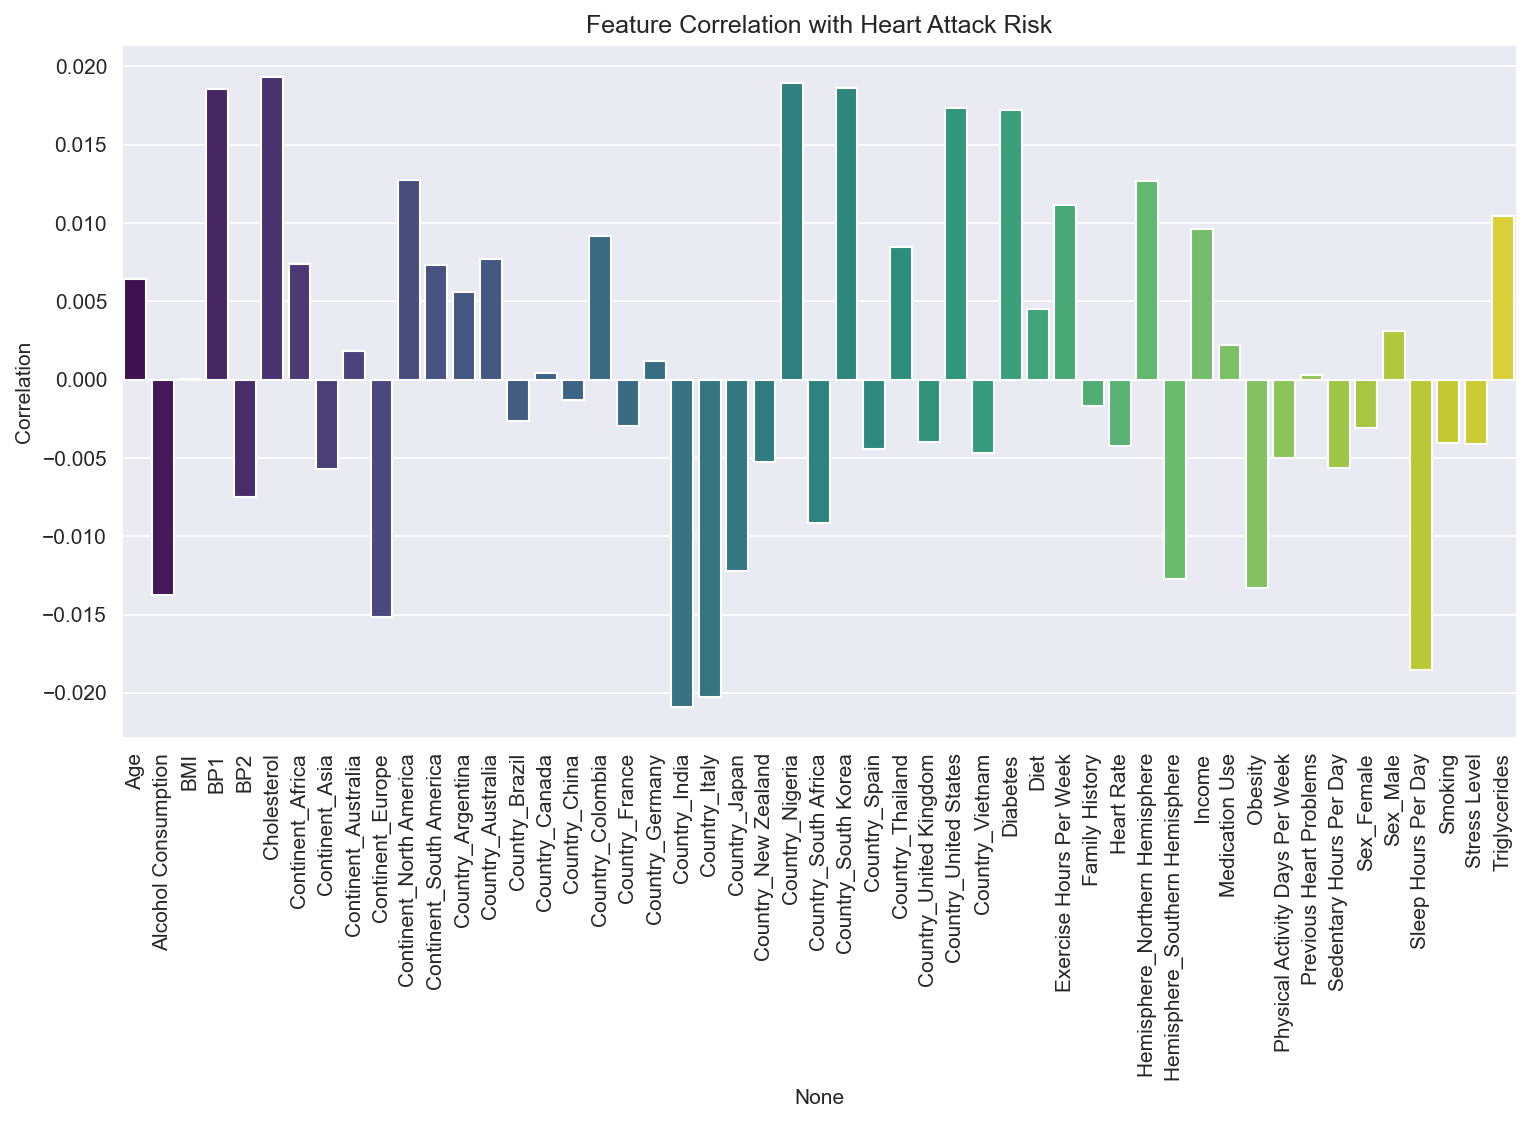

In [23]:
numeric_df = df.select_dtypes(include=['number'])

correlations = numeric_df.corr()['Heart Attack Risk'].drop('Heart Attack Risk')

correlations = correlations.sort_values(ascending=False)

categories = correlations.index.astype('category')

plt.figure(figsize=(12, 6), dpi=150)
sns.barplot(x=categories, y=correlations.values, hue=categories, dodge=False, palette="viridis", legend=False)
plt.title('Feature Correlation with Heart Attack Risk')
plt.ylabel('Correlation')
plt.xticks(rotation=90)
plt.show()

#### List of numerical features

In [24]:
num_features = [
    'Age',
    'Cholesterol',
    'Heart Rate',
    'Diabetes',
    'Family History',
    'Smoking',
    'Obesity',
    'Alcohol Consumption',
    'Exercise Hours Per Week',
    'Previous Heart Problems',
    'Medication Use',
    'Stress Level',
    'Sedentary Hours Per Day',
    'Income',
    'BMI',
    'Triglycerides',
    'Physical Activity Days Per Week',
    'Sleep Hours Per Day',
    'Heart Attack Risk'
]

##### List of categorical features

In [25]:
cat_features = ['Sex', 'Diet', 'Country', 'Continent', 'Hemisphere']

##### Plotting histograms for numerical features

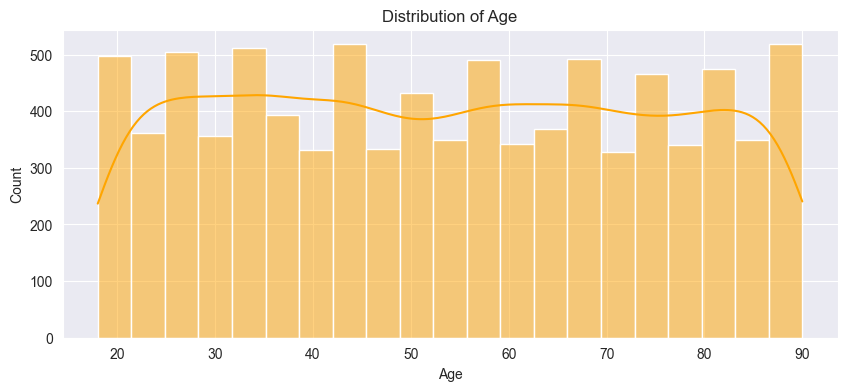

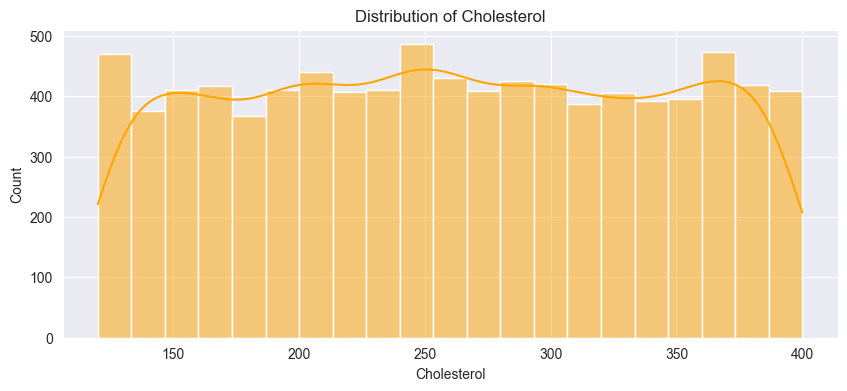

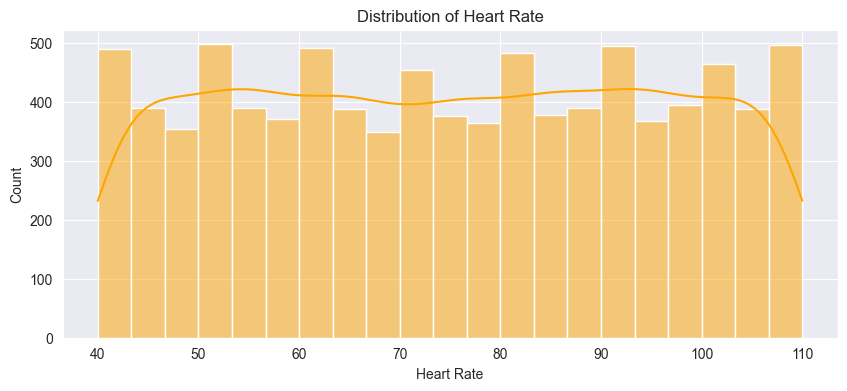

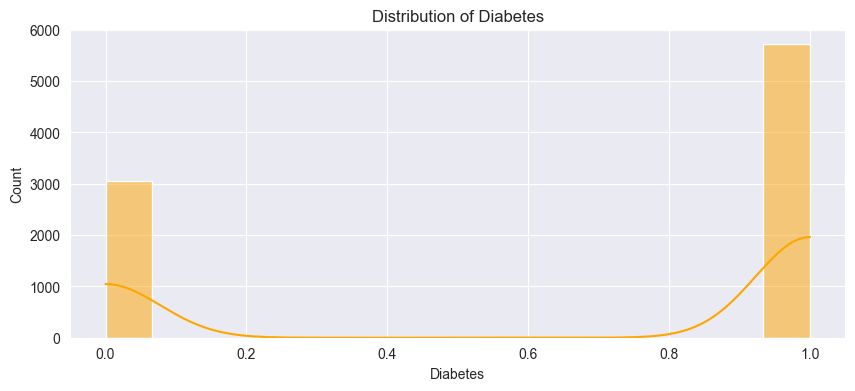

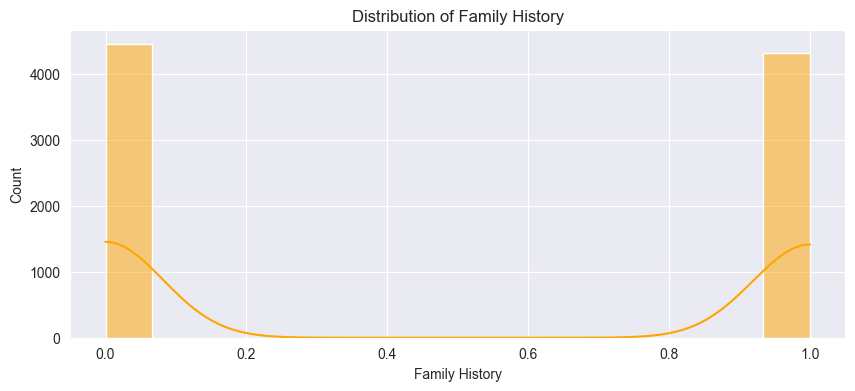

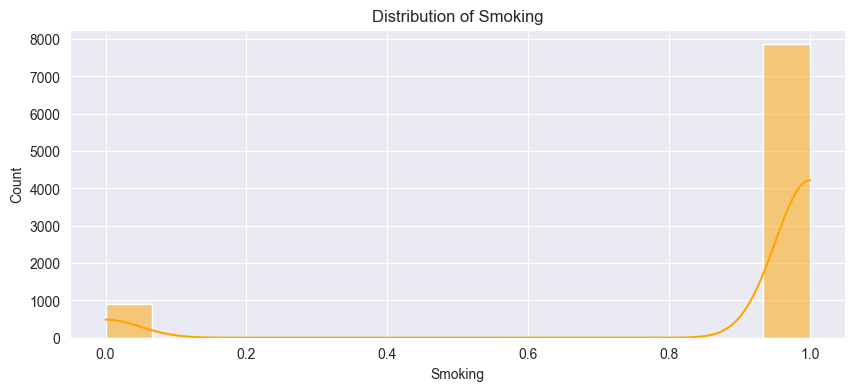

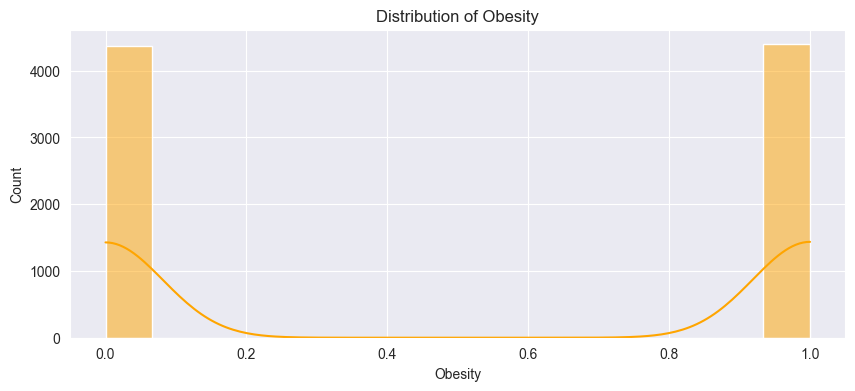

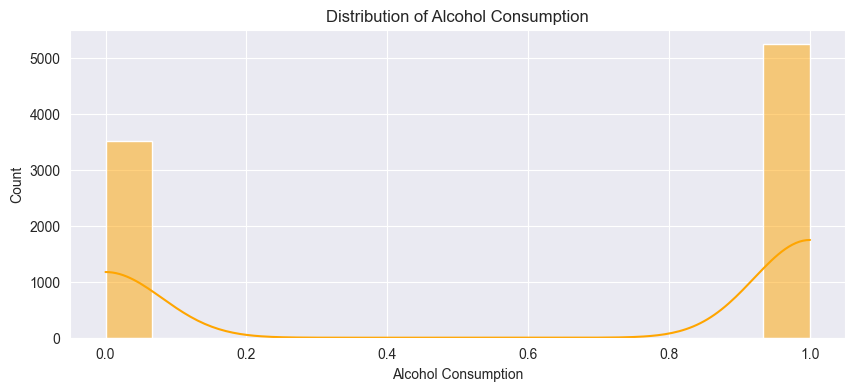

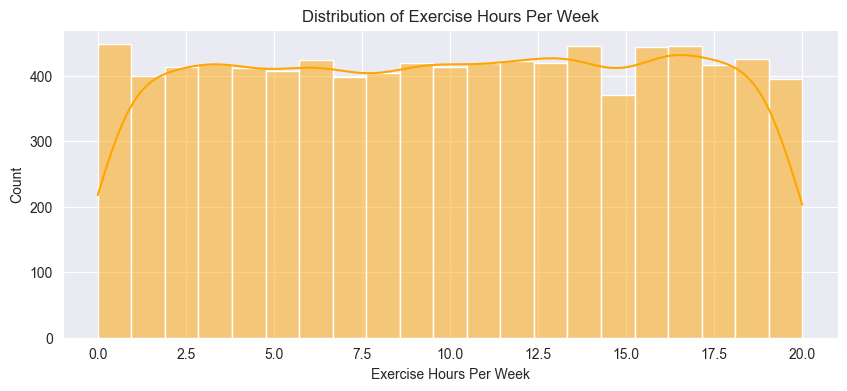

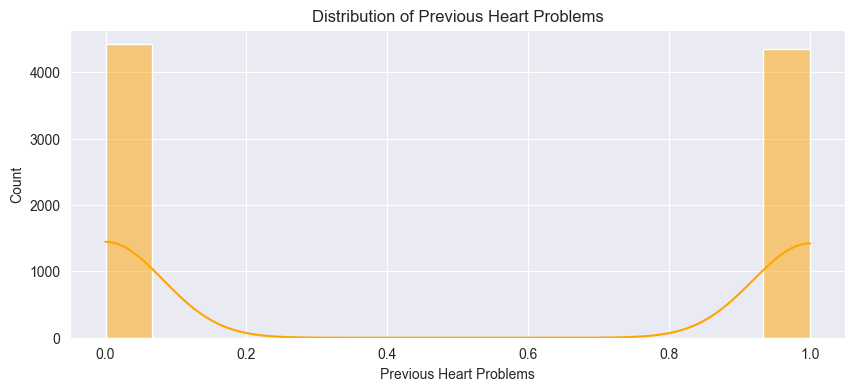

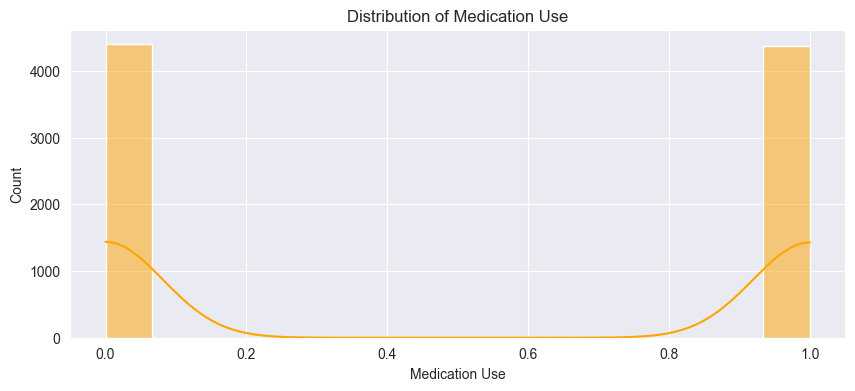

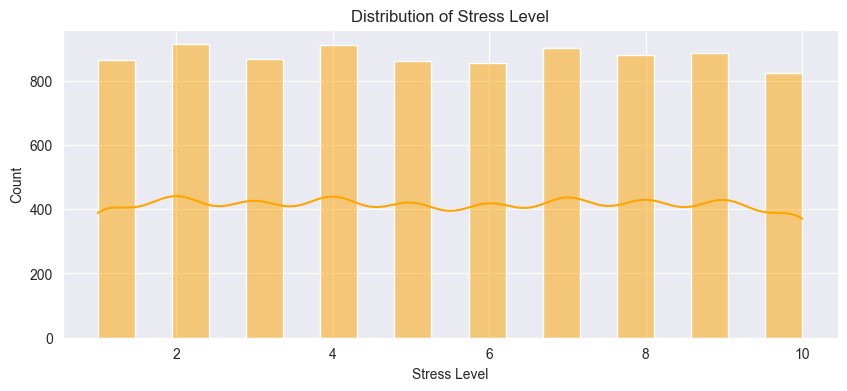

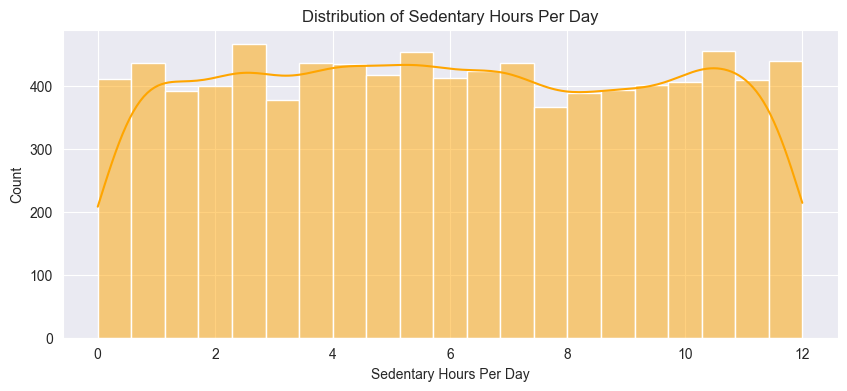

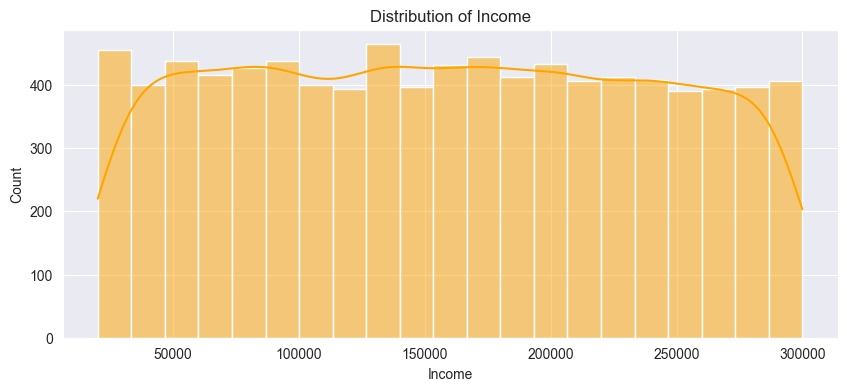

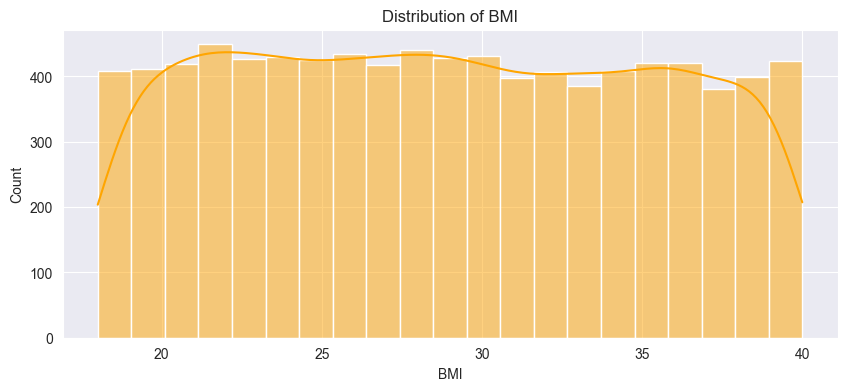

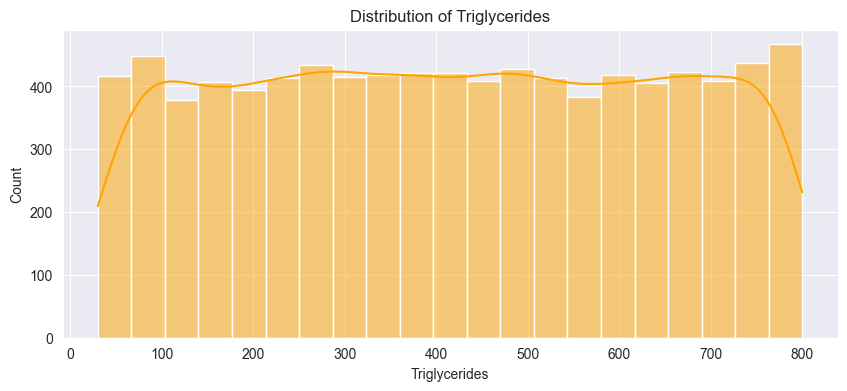

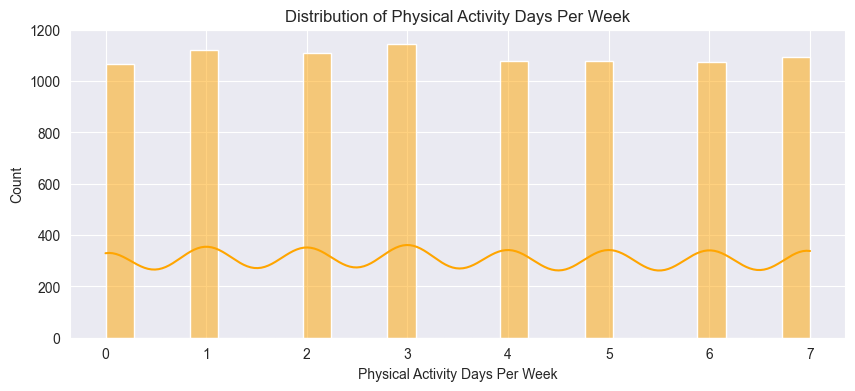

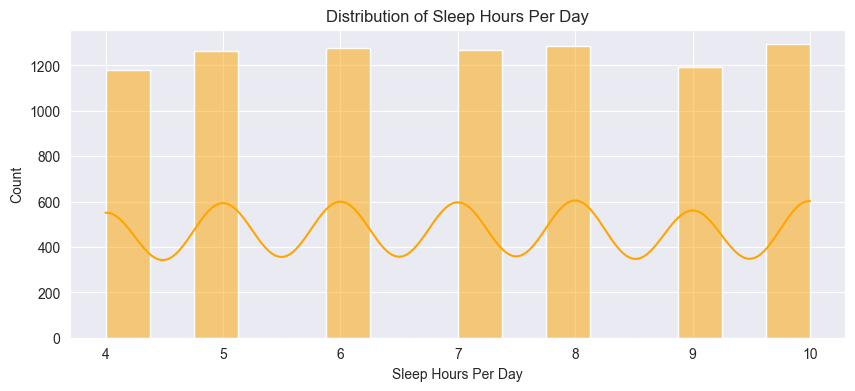

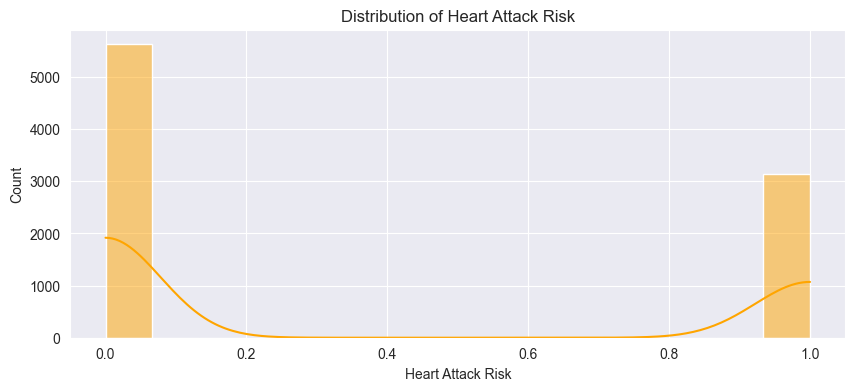

In [26]:
for feature in num_features:
    plt.figure(figsize=(10, 4))
    sns.histplot(data=df_viz, x=feature, kde=True, color="orange")
    plt.title(f'Distribution of {feature}')
    plt.show()

##### Plotting countplots for categorical features

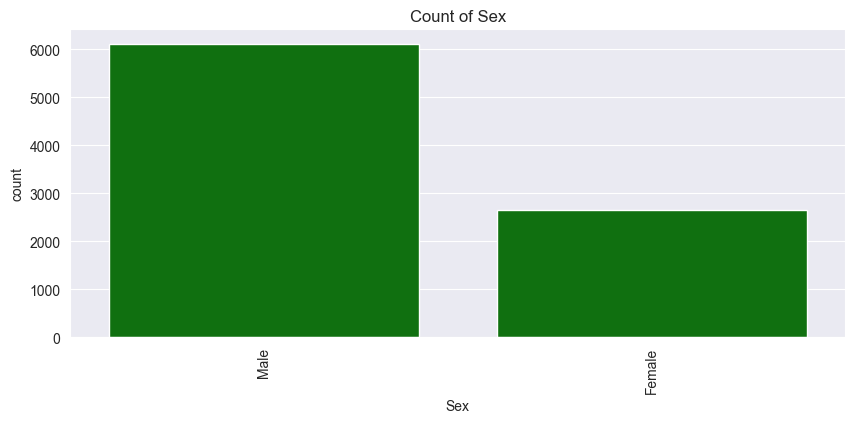

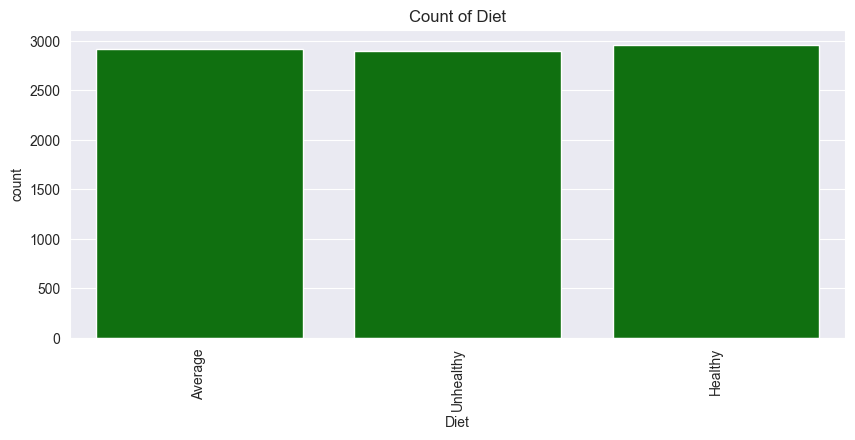

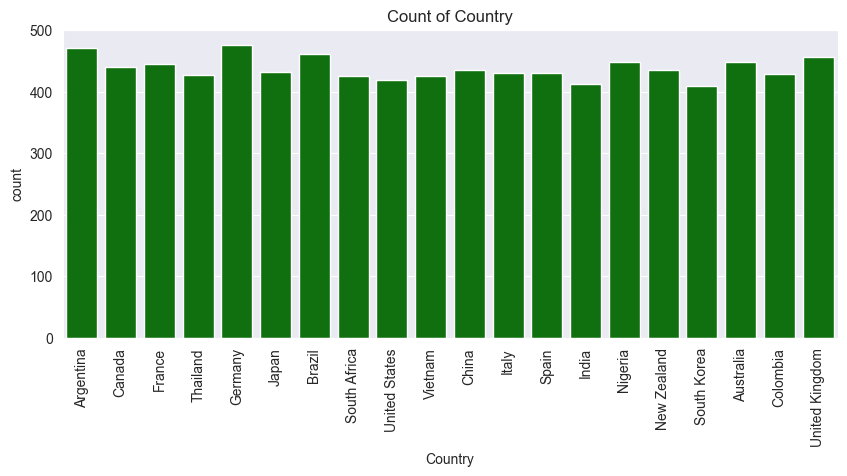

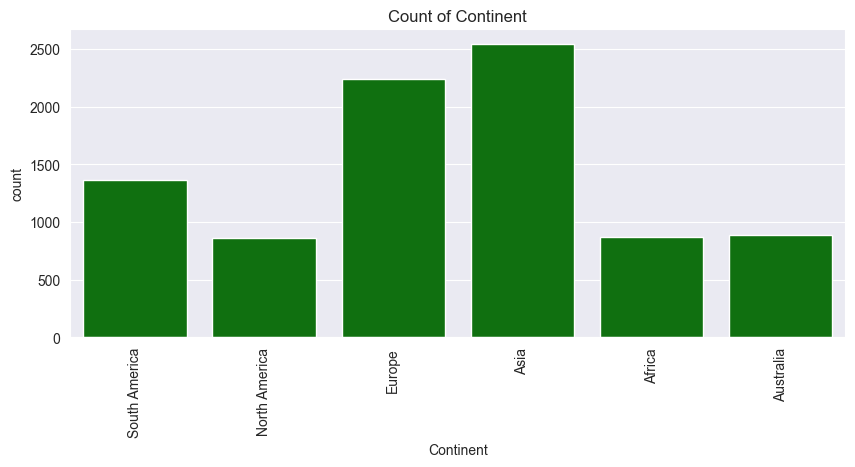

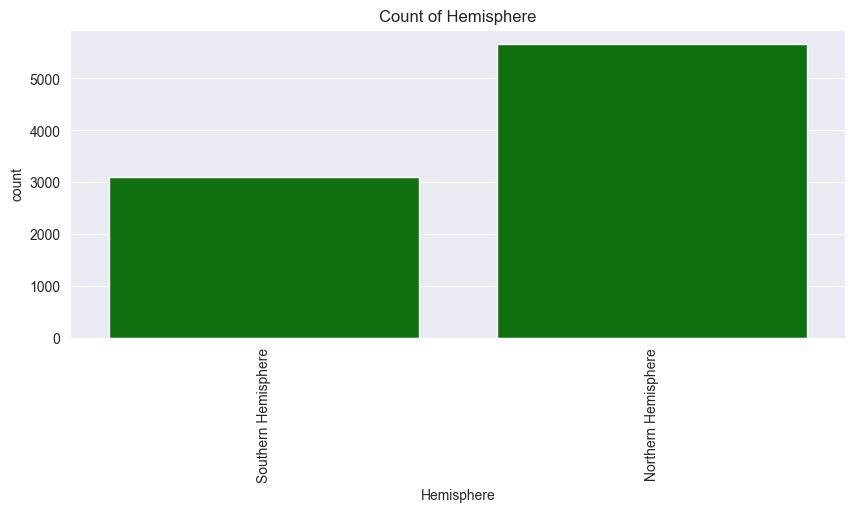

In [27]:
for feature in cat_features:
    plt.figure(figsize=(10,4))
    sns.countplot(data=df_viz, x=feature, color="green")
    plt.title(f'Count of {feature}')
    plt.xticks(rotation=90)
    plt.show()

##### Bar plot for gender-wise counts of heart attack risk

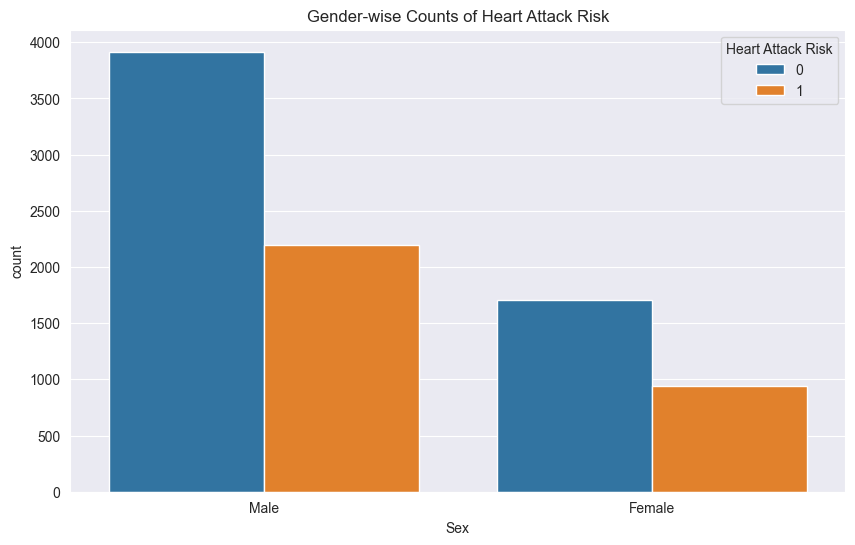

In [28]:
plt.figure(figsize=(10,6))
sns.countplot(data=df_viz, x='Sex', hue='Heart Attack Risk')
plt.title('Gender-wise Counts of Heart Attack Risk')
plt.show()

##### Bar plot for diet-wise counts of heart attack risk

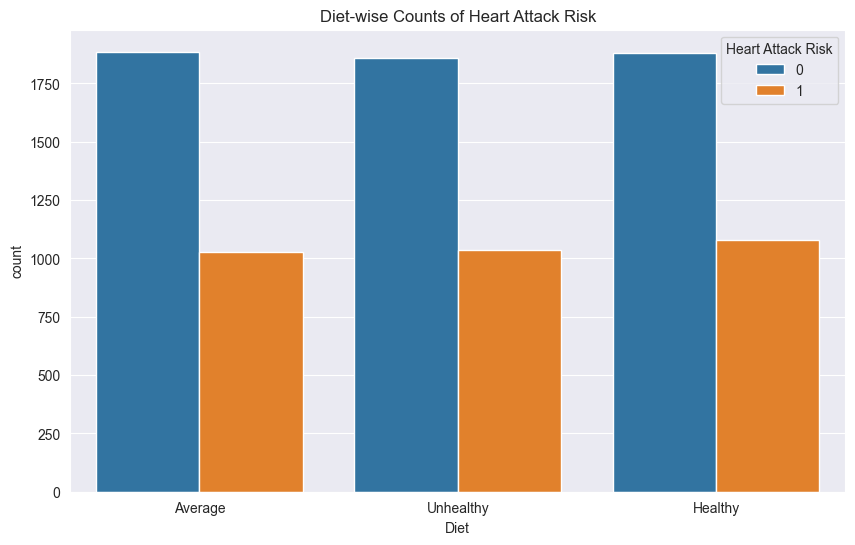

In [29]:
plt.figure(figsize=(10,6))
sns.countplot(data=df_viz, x='Diet', hue='Heart Attack Risk')
plt.title('Diet-wise Counts of Heart Attack Risk')
plt.show()

#### Quantum Machine Learning

##### Data preparing

In [30]:
X = df.drop(columns=['Heart Attack Risk'])
y = df['Heart Attack Risk']

In [31]:
X = X.select_dtypes(include=['number'])

X = X.replace('Average', np.nan)
X = X.dropna()

y = y.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
print(f'X_train.shape: {X_train.shape}, X_test.shape: {X_test.shape}')
print(f'y_train.shape: {y_train.shape}, y_test.shape: {y_test.shape}')
print(f'y_train.value_counts(): {y_train.value_counts()}')
print(f'y_test.value_counts(): {y_test.value_counts()}')
print(f'y_train.mean(): {y_train.mean()}, y_test.mean(): {y_test.mean()}')

X_train.shape: (7010, 51), X_test.shape: (1753, 51)
y_train.shape: (7010,), y_test.shape: (1753,)
y_train.value_counts(): Heart Attack Risk
0    4499
1    2511
Name: count, dtype: int64
y_test.value_counts(): Heart Attack Risk
0    1125
1     628
Name: count, dtype: int64
y_train.mean(): 0.35820256776034237, y_test.mean(): 0.3582430119794638


##### Reduce X_train and X_test to 2 dimensions

In [33]:
def reduce_to_2_dimensions(data):
    """
    Reduces the number of features in the dataset to 2 dimensions by averaging subsets of features.
    
    Args:
        data (Union[np.ndarray, pd.DataFrame]): Input dataset of shape (n_samples, n_features).
    
    Returns:
        np.ndarray: Reduced dataset of shape (n_samples, 2).
    """
    if isinstance(data, pd.DataFrame):
        data = data.to_numpy()

    n_features = data.shape[1]
    split_size = n_features // 2

    reduced_data = np.column_stack([
        np.mean(data[:, :split_size], axis=1),
        np.mean(data[:, split_size:], axis=1)
    ])
    return reduced_data


X_train_red = reduce_to_2_dimensions(X_train)
X_test_red = reduce_to_2_dimensions(X_test)

print(f"X_train Reduced Shape: {X_train_red.shape}")
print(f"X_test Reduced Shape: {X_test_red.shape}")

X_train Reduced Shape: (7010, 2)
X_test Reduced Shape: (1753, 2)


##### Normalize the data

In [34]:
scaler = MinMaxScaler(feature_range=(0, np.pi))
X_train_reduced = scaler.fit_transform(X_train_red[:1000])
X_test_reduced = scaler.transform(X_test_red[:100])

##### Convert y_train and y_test to NumPy arrays

In [35]:
y_train_np = y_train[:1000].to_numpy()
y_test_np = y_test[:100].to_numpy()

##### Reduce number for optimizing

In [36]:
X_train_reduced_opt, y_train_np_opt = X_train_reduced[:100], y_train_np[:100]

##### Class Weights

In [37]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

#### Define the Quantum Feature Map

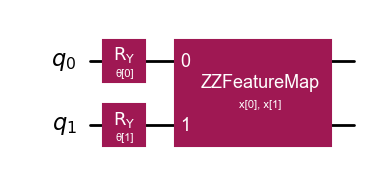

In [38]:
num_qubits = 2 

trainable_params = ParameterVector("θ", 2)

trainable_feature_map = QuantumCircuit(num_qubits)
trainable_feature_map.ry(trainable_params[0], 0)
trainable_feature_map.ry(trainable_params[1], 1)

input_feature_map = ZZFeatureMap(num_qubits)

combined_feature_map = trainable_feature_map.compose(input_feature_map)

combined_feature_map.draw("mpl")

##### Set Up the Quantum Kernel and Quantum Kernel Trainer

In [39]:
sampler = Sampler()
fidelity = ComputeUncompute(sampler=sampler)

quant_kernel = TrainableFidelityQuantumKernel(
    fidelity=fidelity,
    feature_map=combined_feature_map,
    training_parameters=trainable_params
)

spsa_opt = SPSA(
    maxiter=10,
    learning_rate=0.02,
    perturbation=0.01
)

##### Distribute the training process for different initializations across multiple CPU cores.

In [40]:
def train_qkt_with_initial_point(initial_point, X_train, y_train, quant_kernel, loss_function, optimizer):
    """
    Train QuantumKernelTrainer with a specific initial point.
    """
    qkt = QuantumKernelTrainer(
        quantum_kernel=quant_kernel,
        loss=loss_function,
        optimizer=optimizer,
        initial_point=initial_point
    )
    results = qkt.fit(X_train, y_train)
    return results

num_initializations = 4

num_trainable_params = len(quant_kernel.training_parameters)

initial_points = [np.random.randn(num_trainable_params) * 0.1 for _ in range(num_initializations)]

# Parallelize the training process
results = Parallel(n_jobs=-1, verbose=10)(
    delayed(train_qkt_with_initial_point)(
        initial_point,
        X_train_reduced_opt,
        y_train_np_opt,
        quant_kernel,
        loss_function=SVCLoss(),
        optimizer=spsa_opt
    )
    for initial_point in initial_points
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:  5.0min remaining:  5.0min
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  5.0min finished


In [41]:
optimized_kernels = [result.quantum_kernel for result in results]

#### Save the optimized kernel to a file

In [42]:
with open('kernels/optimized_kernel.pkl', 'wb') as f:
    pickle.dump(optimized_kernels, f)

#### Load the optimized kernel from the file

In [43]:
# with open('kernels/optimized_kernel.pkl', 'rb') as f:
#     loaded_kernel = pickle.load(f)

##### Fit the QSVC

In [44]:
for idx, kernel in enumerate(tqdm(optimized_kernels, desc="Training QSVC for each kernel")):
    print(f"Training QSVC with kernel {idx + 1}/{len(optimized_kernels)}...")
    qsvc = QSVC(quantum_kernel=kernel, class_weight=class_weights_dict, probability=True)
    qsvc.fit(X_train_reduced, y_train_np)
    print(f"Finished training QSVC with kernel {idx + 1}/{len(optimized_kernels)}.\n")

Training QSVC for each kernel:   0%|          | 0/4 [00:00<?, ?it/s]

Training QSVC with kernel 1/4...


Training QSVC for each kernel:  25%|██▌       | 1/4 [23:10<1:09:30, 1390.06s/it]

Finished training QSVC with kernel 1/4.

Training QSVC with kernel 2/4...


Training QSVC for each kernel:  50%|█████     | 2/4 [46:34<46:37, 1398.50s/it]  

Finished training QSVC with kernel 2/4.

Training QSVC with kernel 3/4...


Training QSVC for each kernel:  75%|███████▌  | 3/4 [1:09:57<23:20, 1400.63s/it]

Finished training QSVC with kernel 3/4.

Training QSVC with kernel 4/4...


Training QSVC for each kernel: 100%|██████████| 4/4 [1:33:14<00:00, 1398.67s/it]

Finished training QSVC with kernel 4/4.



#### Save model

In [45]:
qsvc.save('models/QSVC_quantm_trainer.model')

#### Predict on the test and train sets

In [46]:
labels_train = qsvc.predict(X_train_reduced)
labels_test = qsvc.predict(X_test_reduced)

#### Evalaute the test accuracy

In [47]:
accuracy_test = metrics.balanced_accuracy_score(y_true=y_test_np, y_pred=labels_test)
print(f"accuracy test: {accuracy_test}")

accuracy test: 0.564312736443884


#### Evaluate the model

In [49]:
accuracy_train = metrics.accuracy_score(y_train_np, labels_train)
accuracy_train = metrics.accuracy_score(y_train_np, labels_train)
rmse_train = np.sqrt(metrics.root_mean_squared_error(y_train_np, labels_train))
conf_matrix_train = metrics.confusion_matrix(y_train_np, labels_train)
class_report_train = metrics.classification_report(y_train_np, labels_train, output_dict=True, zero_division=0)
class_report_df_train = pd.DataFrame(class_report_train).transpose()

print(f"Model Accuracy on Training Data: {accuracy_train * 100:.2f}% \n")
print(f"Root Mean Squared Error (RMSE) on Training Data: {rmse_train:.2f} \n")
print(f"Confusion Matrix on Training Data: \n{conf_matrix_train}\n")
print("Classification Report on Training Data:")
print(class_report_df_train)

Model Accuracy on Training Data: 65.80% 

Root Mean Squared Error (RMSE) on Training Data: 0.76 

Confusion Matrix on Training Data: 
[[438 203]
 [139 220]]

Classification Report on Training Data:
              precision    recall  f1-score   support
0              0.759099  0.683307  0.719212   641.000
1              0.520095  0.612813  0.562660   359.000
accuracy       0.658000  0.658000  0.658000     0.658
macro avg      0.639597  0.648060  0.640936  1000.000
weighted avg   0.673296  0.658000  0.663010  1000.000


#### Plot precision, recall, and F1-score as bar charts

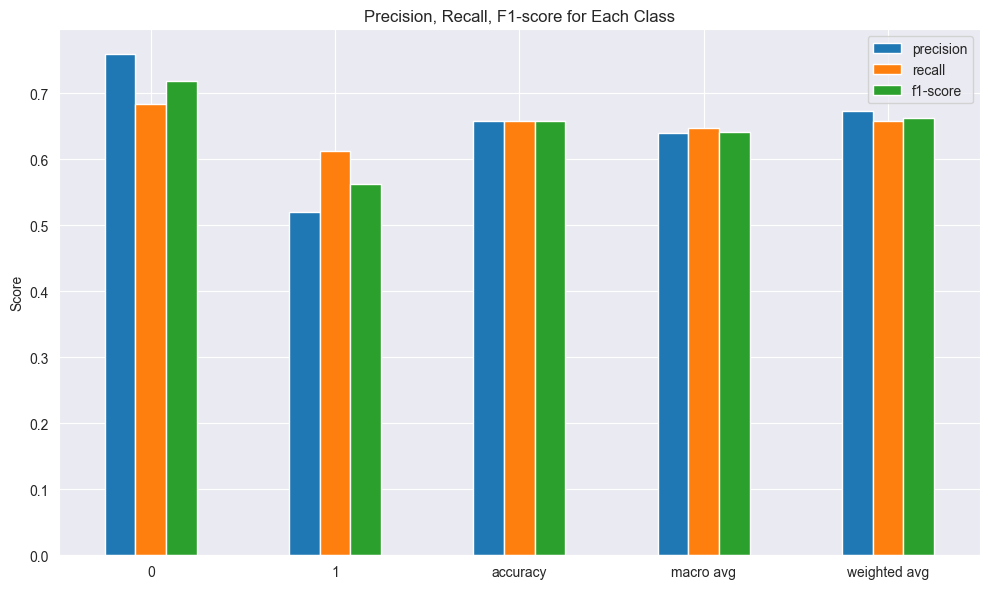

In [50]:
class_report_train = metrics.classification_report(y_train_np, labels_train, output_dict=True, zero_division=0)
metrics_df = pd.DataFrame(class_report_train).transpose()
metrics_df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(10, 6))
plt.title('Precision, Recall, F1-score for Each Class')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

##### Plotting the actual vs. predicted values

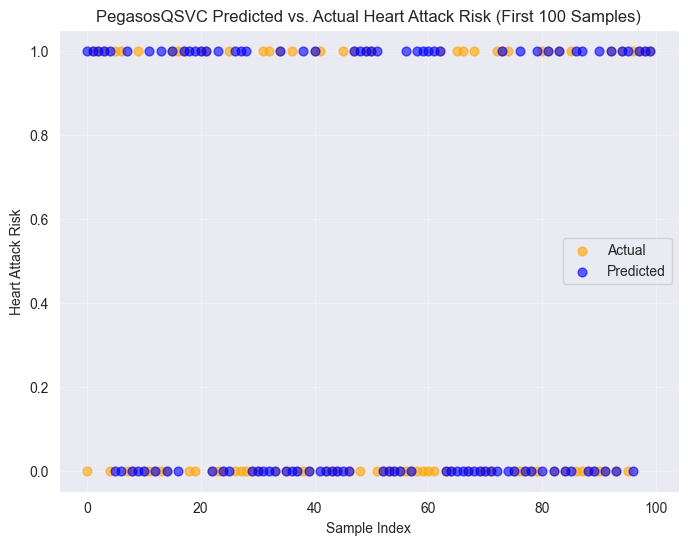

In [51]:
plt.figure(figsize=(8, 6))
plt.scatter(range(len(y_test_np[:100])), y_test_np[:100], label="Actual", color="orange", alpha=0.6, s=40)
plt.scatter(range(len(labels_test[:100])), labels_test[:100], label="Predicted", color="blue", alpha=0.6, s=40)
plt.xlabel("Sample Index")
plt.ylabel("Heart Attack Risk")
plt.title("PegasosQSVC Predicted vs. Actual Heart Attack Risk (First 100 Samples)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

##### Line plot of the first 100 predicted heart attack risks

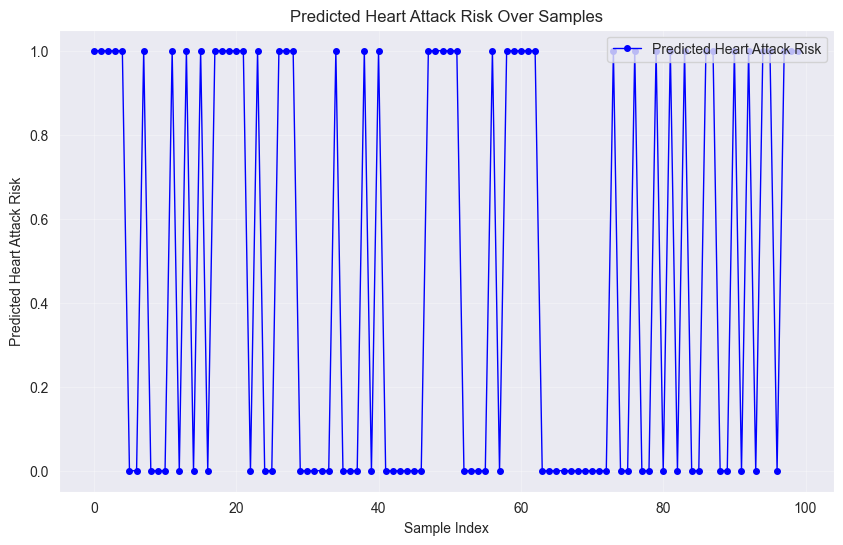

In [52]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(labels_test[:100])), labels_test[:100], label="Predicted Heart Attack Risk", color='blue', marker='o', linestyle='-', linewidth=1, markersize=4)
plt.xlabel("Sample Index")
plt.ylabel("Predicted Heart Attack Risk")
plt.title("Predicted Heart Attack Risk Over Samples")
plt.legend(loc='upper right')
plt.grid(alpha=0.3)
plt.show()

##### Scatter plot of the reduced test data with predictions

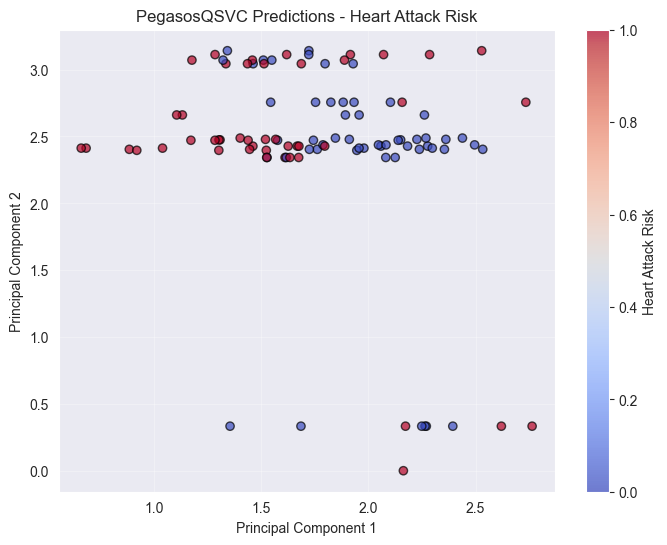

In [53]:
plt.figure(figsize=(8, 6))
plt.scatter(X_test_reduced[:, 0], X_test_reduced[:, 1], c=labels_test, cmap='coolwarm', marker='o', edgecolor='k', alpha=0.7)
plt.colorbar(label='Heart Attack Risk')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PegasosQSVC Predictions - Heart Attack Risk')
plt.grid(alpha=0.3)
plt.show()

#### Plot Confusion Matrix

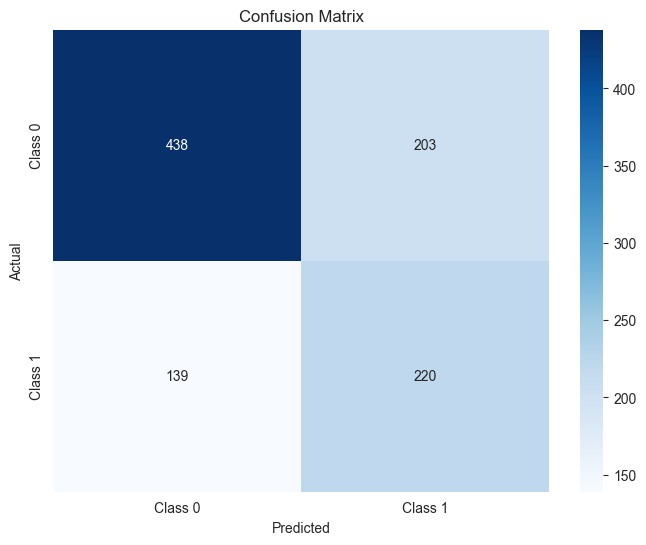

In [54]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#### Load model

In [55]:
loaded_model = QSVC.load('models/QSVC_quantm_trainer.model')

#### Test loaded model

In [56]:
train_score = loaded_model.score(X_train_reduced[:100], y_train_np[:100])
test_score = loaded_model.score(X_test_reduced[:100], y_test_np[:100])

print(f"Quantum PegasosQSVC on the training dataset: {train_score:.2f}")
print(f"Quantum PegasosQSVC on the test dataset: {test_score:.2f}")

Quantum PegasosQSVC on the training dataset: 0.65
Quantum PegasosQSVC on the test dataset: 0.61


In [57]:
import utils.tutorial_magics

%qiskit_version_table
%qiskit_copyright